# 数据预处理

数据预处理包含：
 1. 数据清洗：数据的质量问题会严重影响数据分析挖掘的工作量和结果，严重的问题可能会导致结果偏差。
 2. 数据集成：将不同的数据集成起来，让数据具备更多的特征以支持分析。
 3. 数据变换：数据变换主要是对数据进行规范化处理，将数据转换为“适当的”形式，以适应于挖掘任务及算法的需要。
 4. 数据规约：也可以理解成数据标准化。

## 1. 数据清洗
我们知道影响数据质量的因素有：缺失、不一致、异常值、重复、包含特殊符号等。同时以数学方法帮助进行数据清洗的手段主要有以下两种：
 * 缺失值处理
 * 异常值处理

其他的问题如：不一致问题、重复、包含特殊符号等问题，可以和业务人员讨论业务规则来进行处理。不一致问题在文本挖掘中可能会变成一个实体识别或同义词识别的问题。

### 1.1 缺失值处理

缺失值处理的主要方法有以下几种：
 * 均值/中位数/众数：根据属性值的类型，用该属性取值的平均数/中位数/众数进行插补
 * 使用固定值：将缺失的属性值用一个常量替换。例如一些时候，将字段“在Java领域的工作经验”使用零来填充。
 * 最近临插补：在记录中找到与缺失样本最接近的样本的该属性值插补。
 * 回归方法：对带缺失值的变量，根据已有数据和与其有关的其他变量（因变量）的数据建立拟合模型来预测缺失的属性值。
 * 插值法：插值法是利用已知点建立合适的插值函数，未知值由对应点求出的函数值近似代替。

当然如果缺失值的数据数据很小的部分，也许删除小部分记录是最高效的处理方法。但是也很有可能会丢弃了大量隐藏在这些记录中的信息，因为重要的信息往往包含在很少的记录之中。

也有一些模型可以将缺失值视作一种特殊的取值，也相当于使用了“固定值”的方法来处理。

#### 插值法

* 拉格朗日插值法
* 牛顿插值法
* Hermite插值法
* 分段插值法
* 样条插值法

**回到餐饮系统中的销量数据的问题，出现了几天的销售数据为空，或者销售数据异常。**在这种情况下，可以使用拉格朗日插值法对缺失值进行插补。

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') #为了整洁，去除弹出的warnings

In [2]:
input_file = '../data/catering_sale.xls'

data = pd.read_excel(input_file)
data[u'销量'][(data[u'销量'] < 400) | (data[u'销量'] > 5000)] = None

In [3]:
from scipy.interpolate import lagrange

#自定义列向量插值函数
#s为列向量，n为被插值的位置，k为取前后的数据个数，默认为5
def ployinterp_column(s, n, k=5):
    y = s[list(range(n-k, n)) + list(range(n+1, n+1+k))] #取数
    y = y[y.notnull()] #剔除空值
    # print(y.index - n + k, list(y), lagrange(y.index - n + k, list(y))(k))
    return lagrange(y.index - n + k, list(y))(k) #插值并返回插值结果

In [4]:
#逐个元素判断是否需要插值
for i in data.columns:
    for j in range(len(data)):
        if (data[i].isnull())[j]: #如果为空即插值。
            data[i][j] = ployinterp_column(data[i], j)

data.to_excel('../data/fixed_sales.xls') #输出结果，写入文件

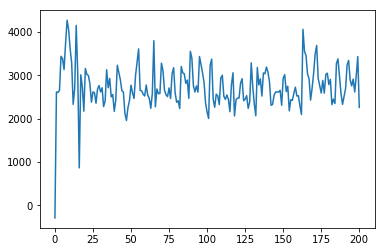

In [5]:
import matplotlib.pyplot as plt

plt.plot(data.index, data.values[:,1])
plt.show()

### 1.2 异常值处理

在数据预处理时，异常值是否剔除，需视具体情况而定，因为有些异常值可能蕴含着有用的信息。异常值处理的常用方法如下：
 * 删除含有异常值的记录：直接将含有异常值的记录删除
 * 视为缺失值：将异常值视为缺失值，利用缺失值处理的方法进行处理
 * 平均值修正：可用前后两个观测值的平均值修正该异常值
 * 不处理： 直接在具有异常值的数据集上进行挖掘建模

很多情况下，要先分析异常值出现的可能原因，在判断异常值是否应该舍弃，如果是正确的数据，可以直接在具有异常值的数据集上进行挖掘建模。

## 2. 数据集成
数据挖掘需要的数据往往分布在不同的数据源中，数据集成就是将多个数据源合并存放在一个一致的数据存储中的过程。

来自多个数据源的现实世界实体的表达形式是不一样的，有可能不匹配，所以在数据集成的过程中，问题最大的就是数据的：
 * 一致性问题 => 实体识别
 * 重复等问题 => 冗余属性识别
 * 以及特殊符号导致的不匹配问题。

### 2.1 实体识别
实体识别是指从不同数据源识别出现实世界的实体，它的任务是统一不同数据源的矛盾之处，常见的形式有
- **同名同义**：数据源A中的属性ID和数据源B中的属性ID分别描述的是不同编号，即描述的是不同的实体
- **异名同义**：数据源A的dt和数据源的date都是描述日期的，即A.dt = B.date
- **单位不统一**：描述同一个实体分别用的国际单位和中国传统的计量单位
检测和解决这些冲突就是实体识别的任务

### 2.2 冗余属性识别
数据集成往往导致数据冗余，如：
- 同一属性多次出现
- 同一属性命名不一致导致重复
仔细整合不同源数据能减少甚至避免数据冗余与不一致，从而提高数据挖掘的速度和质量，对于冗余属性要先分析，检测到后再将其删除。有些冗余属性可以用相关分析检测

## 3. 数据变换
数据变换主要是对数据进行规范化处理，将数据转换为“适当的”形式，以适应于挖掘任务及算法的需要。

### 3.1 简单函数变换
对原始数据进行某些数学函数变换，常用的变换包括平方、开发、取对数、差分运算等。简单的函数变换常用来将不具有正态分布的数据变换成具有正态分布的数据。有时间序列分析中，有时简单的对数变换或者差分运算就可以将非平稳序列转换成平稳序列。在数据挖掘中，简单的函数变换可能更有必要，比如个人年收入的取值范围为10000元到10亿元，这是一个很大的区间，使用对数变换对其进行压缩是常用的一种变换处理方法

### 3.2 规范化
数据规范化处理是数据挖掘的一项基础工作。不同评价指标往往具有不同的量纲，数值间的差别可能很大，不进行处理可能会影响到数据分析的结果。为了消除指标之间的量纲和取值范围差异的影响，需要进行标准化处理，将数据按照比例进行缩放，是之落入一个特定的区域，便于进行综合分析。数据规范化对于基于距离的挖掘算法尤为重要。
- **最小-最大规范化**：也称离差标准化，是对原始数据的线性变换，将数值映射到[0,1]之间。
	* 离差标准化保留了原来数据中存在的关系，是消除量纲和数据取值范围影响的最简单方法。
	* 缺点：若数值集中且某个数值很大，则规范化后各值会接近于0，并且将会相差不大，若将来遇到超过目前属性[min,max]取值范围的时候，会引起系统出错，需要重新确定min和max
- **零-均值规范化**：也称标准差标准化，经过处理的数据均值为0，标准差为1
- **小数定标规范化**：通过移动属性值的小数位数，将属性值映射到[-1,1]之间，移动的小数位数取决属性值绝对值的最大值：x^{*} = x / 10^{k}

In [6]:
datafile = '../data/normalization_data.xls' #参数初始化
data = pd.read_excel(datafile, header = None) #读取数据
data

,0,1,2,3
0,78,521,602,2863
1,144,-600,-521,2245
2,95,-457,468,-1283
3,69,596,695,1054
4,190,527,691,2051
5,101,403,470,2487
6,146,413,435,2571


In [7]:
(data - data.min())/(data.max() - data.min()) #最小-最大规范化

,0,1,2,3
0,0.074380,0.937291,0.923520,1.000000
1,0.619835,0.000000,0.000000,0.850941
2,0.214876,0.119565,0.813322,0.000000
3,0.000000,1.000000,1.000000,0.563676
4,1.000000,0.942308,0.996711,0.804149
5,0.264463,0.838629,0.814967,0.909310
6,0.636364,0.846990,0.786184,0.929571


In [8]:
(data - data.mean())/data.std() #零-均值规范化

,0,1,2,3
0,-0.905383,0.635863,0.464531,0.798149
1,0.604678,-1.587675,-2.193167,0.369390
2,-0.516428,-1.304030,0.147406,-2.078279
3,-1.111301,0.784628,0.684625,-0.456906
4,1.657146,0.647765,0.675159,0.234796
5,-0.379150,0.401807,0.152139,0.537286
6,0.650438,0.421642,0.069308,0.595564


In [9]:
data/10**np.ceil(np.log10(data.abs().max())) #小数定标规范化

,0,1,2,3
0,0.078,0.521,0.602,0.2863
1,0.144,-0.600,-0.521,0.2245
2,0.095,-0.457,0.468,-0.1283
3,0.069,0.596,0.695,0.1054
4,0.190,0.527,0.691,0.2051
5,0.101,0.403,0.470,0.2487
6,0.146,0.413,0.435,0.2571


### 3.3 连续属性离散化
一些数据挖掘算法，特别是某些分类算法如ID3算法，Apriori算法等，要求数据是分类属性形式。这样，常常需要将连续属性变换成分类属性，即连续性离散化
- **离散化的过程**：连续属性的离散化就是在数据的取值范围设定若干个离散的划分点，将取值范围划分为一些离散化的区间，最后用不同的符号或整数值代表落在每个子区间中的数据值。所以，离散化涉及两个子任务：确定分类数以及如何将连续属性值映射到这些分类值。
- **常用的离散化方法**：
	* **等宽法**：将属性的值域分成具有相同宽度的区间，区间的个数由数据本身的特点决定，或者由用户制定，类似于制作频率分布表
	* **等频法**：将相同数量的记录放进每个区间
	* 这两种方法简单，易于操作，但都需要人为地规定划分区间的个数。同时等宽法的缺点在于它对离群点比较敏感，倾向于不均匀地把属性值分布到各个区间。有些区间包含许多数据，而另一些区间的数据极少，这样严重损坏建立的决策模型。等频法虽然避免了上述问题的产生，却可能将相同的数据值分到不同的区间以满足每个区间中固定的数据个数
	* **基于聚类分析的方法**：一维聚类的方法包括两个步骤，首先将连续属性的值用聚类算法如K-Means算法进行聚类，然后再将聚类得到的簇进行处理，合并到一个簇的连续属性值并做同一标记。聚类分析的离散化方法也需要用户指定簇的个数，从而决定产生的区间数。

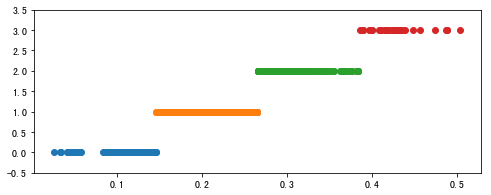

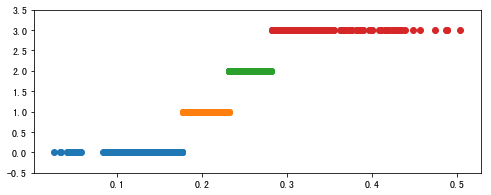

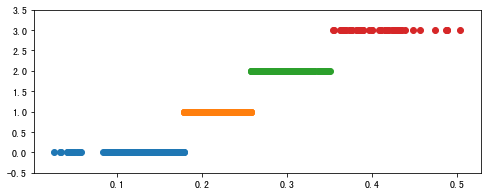

In [10]:
#数据规范化
datafile = '../data/discretization_data.xls' #参数初始化
data = pd.read_excel(datafile) #读取数据
data = data[u'肝气郁结证型系数'].copy()
k = 4

d1 = pd.cut(data, k, labels = range(k)) #等宽离散化，各个类比依次命名为0,1,2,3

#等频率离散化
w = [1.0*i/k for i in range(k+1)]
w = data.describe(percentiles = w)[4:4+k+1] #使用describe函数自动计算分位数
w[0] = w[0]*(1-1e-10)
d2 = pd.cut(data, w, labels = range(k))

from sklearn.cluster import KMeans #引入KMeans
kmodel = KMeans(n_clusters = k, n_jobs = 4) #建立模型，n_jobs是并行数，一般等于CPU数较好
kmodel.fit(data.reshape((len(data), 1))) #训练模型
# c = pd.DataFrame(kmodel.cluster_centers_).sort(0) #输出聚类中心，并且排序（默认是随机序的）
c = pd.DataFrame(kmodel.cluster_centers_).sort_values(0) #输出聚类中心，并且排序（默认是随机序的）
w = pd.rolling_mean(c, 2).iloc[1:] #相邻两项求中点，作为边界点
w = [0] + list(w[0]) + [data.max()] #把首末边界点加上
d3 = pd.cut(data, w, labels = range(k))

def cluster_plot(d, k): #自定义作图函数来显示聚类结果
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
  
    plt.figure(figsize = (8, 3))
    for j in range(0, k):
        plt.plot(data[d==j], [j for i in d[d==j]], 'o')
  
    plt.ylim(-0.5, k-0.5)
    return plt

cluster_plot(d1, k).show()

cluster_plot(d2, k).show()
cluster_plot(d3, k).show()

### 3.4 属性构造
在数据挖掘的过程中，为了提取更有用的信息，挖掘更深层次的模式，提高挖掘结果的精度，我们需要利用已有的属性集构造出新的属性，并加入到现有的属性集合中。

In [20]:
#线损率属性构造

#参数初始化
inputfile= '../data/electricity_data.xls' #供入供出电量数据
outputfile = './tmp/electricity_data.xls' #属性构造后数据文件

data = pd.read_excel(inputfile) #读入数据
data[u'线损率'] = (data[u'供入电量'] - data[u'供出电量'])/data[u'供入电量']

from os import mkdir
mkdir('./tmp')

data.to_excel(outputfile, index = False) #保存结果

### 3.4 小波变换
小波变换是一种新型的数据分析工具，是近年来兴起的信号分析手段。小波分析的理论和方法在信号处理、图像处理、语音处理、模式识别、量子物理等领域得到越来越广泛的应用，被认为是近年来在工具及方法上的重大突破。小波变换具有多分辨率的特点，在时域和频域都具有表征信号局部特征的能力，通过伸缩和平移等运算过程对信号进行多尺度聚焦分析，提供了一种非平稳信号的时频分析手段，可以由粗及细地逐步观察信号，从中提取有用信息。

能够刻画某个问题的特征量往往是隐含在一个信号中的某个或者某些分量中，小波变换可以把非平稳信号分解为表达不同层次、不同频带信息的数据序列，即小波系数。选取适当的小波系数，即完成了信号的特征提取。小波变换的信号特征提取方法有：
- **基于小波变换的多尺度空间能量分布特征提取**：各尺度空间内的平滑信号和细节信号能提供原始信号的时频局域信息，特别是能提供不同频段上信号的构成信息。把不同分解尺度上信号的能量求解出来，就可以将这些能量尺度顺序排列，形成特征向量供识别用
- **基于小波变换的多尺度空间的模极大值特征提取**：利用小波变换的信号局域分析能力，求解小波变换的模极大值特性来检测信号的局部奇异性，将小波变换模极大值的尺度参数s、平移参数t及其幅值作为目标的特征量
- **基于小波包变换的特征提取**：利用小波分解，可将时域随机信号序列映射为尺度域各子空间内的随机系数序列，按小波包分解得到的最佳子空间内随机系数序列的不确定性程度最低，将最佳子空间的熵值及最佳子空间在完整二叉树中的位置参数作为特征量，可以用于目标识别
- **基于适应性小波神经网络的特征提取**：基于适应性小波神经网络的特征提取方法可以把信号通过分析小波拟合表示，进行特征提取

**小波基函数**：是一种具有局部支集的函数，并且平均值为0，小波基函数满足†(0)=0，常用的小波基有Haar小波基、db系列小波基

**基于小波变换的多尺度空间能量分布特征提取方法**：应用小波分析技术可以把信号在各频率波段中的特征提取出来，基于小波变换的多尺度空间能量分布特征提取方法是对信号进行频带分析，再分别以计算所得的各个频带的能量作为特征向量

In [13]:
#利用小波分析进行特征分析

#参数初始化
inputfile= '../data/leleccum.mat' #提取自Matlab的信号文件

from scipy.io import loadmat #mat是MATLAB专用格式，需要用loadmat读取它
mat = loadmat(inputfile)
signal = mat['leleccum'][0]

import pywt #导入PyWavelets
coeffs = pywt.wavedec(signal, 'bior3.7', level = 5)
#返回结果为level+1个数字，第一个数组为逼近系数数组，后面的依次是细节系数数组

## 4. 数据规约
在大数据集上进行复杂的数据分析和挖掘需要很长的时间，数据规约产生更小但保持原数据完整性的新数据集。在规约后的数据集上进行分析和挖掘将更有效率。数据规约的意义在于： 
- 降低无效，错误数据对建模的影响，提高建模的准确性
- 少量且具代表性的数据将大幅度缩减数据挖掘所需的时间
- 降低存储数据的成本


### 4.1 属性规约
通过属性合并来创建新属性维数，或者直接通过删除不相关的属性来减少数据维数，从而提高数据挖掘的效率，降低计算成本。属性规约的目标是寻找最小的属性子集并确保新数据子集的概率分布尽可能地接近原来数据集的概率分布，属性规约常用方法有： 
- **合并属性**：将一些旧属性合为新属性
- **逐步向前选择**：从一个空属性集开始，每次从原来属性集合中选择一个当前最优的属性添加到当前属性子集中。直到无法选择出最优属性或满足一定域值约束为止
- **逐步向后选择**：从一个全属性集开始，每次从当前属性子集中选择一个单前最差的属性并将其从当前属性子集中消去。直到无法选择出最差属性为止或满足一定域值约束为止
- **决策树归纳**：利用决策树的归纳方法对初始数据进行分类归纳学习，获得一个初始数据进行分类归纳学习，获得一个初始决策树，所有没有出现在这个决策树上的属性均可以认为是无关属性，因此将这些属性从初始集合中删除，就可以获得一个较优的属性子集
- **主成分分析**：用较少的变量去解释原始数据中的大部分变量，即将许多相关性很高的变量转化成彼此相互独立或不相关的变量

逐步向前选择、逐步向后删除和决策树归纳是属于直接删除不相关属性方法。主成分分析是一种用于连续属性的数据降维方法，它构造了原始数据的一个正交变换，新空间的基底去除了原始空间基底下数据的相关性，只需使用少数新变量就能够结实原始数据中的大部分变异。在应用中，通常是选出比原始变量个数少，能解释大部分数据中的变量的几个新变量，即所谓主成分，来代替原始变量进行建模


In [14]:
#主成分分析 降维

#参数初始化
inputfile = '../data/principal_component.xls'
outputfile = './tmp/dimention_reducted.xls' #降维后的数据

data = pd.read_excel(inputfile, header = None) #读入数据

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
pca.components_ #返回模型的各个特征向量

array([[ 0.56788461,  0.2280431 ,  0.23281436,  0.22427336,  0.3358618 ,
         0.43679539,  0.03861081,  0.46466998],
       [ 0.64801531,  0.24732373, -0.17085432, -0.2089819 , -0.36050922,
        -0.55908747,  0.00186891,  0.05910423],
       [-0.45139763,  0.23802089, -0.17685792, -0.11843804, -0.05173347,
        -0.20091919, -0.00124421,  0.80699041],
       [-0.19404741,  0.9021939 , -0.00730164, -0.01424541,  0.03106289,
         0.12563004,  0.11152105, -0.3448924 ],
       [-0.06133747, -0.03383817,  0.12652433,  0.64325682, -0.3896425 ,
        -0.10681901,  0.63233277,  0.04720838],
       [ 0.02579655, -0.06678747,  0.12816343, -0.57023937, -0.52642373,
         0.52280144,  0.31167833,  0.0754221 ],
       [-0.03800378,  0.09520111,  0.15593386,  0.34300352, -0.56640021,
         0.18985251, -0.69902952,  0.04505823],
       [-0.10147399,  0.03937889,  0.91023327, -0.18760016,  0.06193777,
        -0.34598258, -0.02090066,  0.02137393]])

In [16]:
pca.explained_variance_ratio_ #返回各个成分各自的方差百分比

array([  7.74011263e-01,   1.56949443e-01,   4.27594216e-02,
         2.40659228e-02,   1.50278048e-03,   4.10990447e-04,
         2.07718405e-04,   9.24594471e-05])

In [17]:
pca = PCA(3)
pca.fit(data)

low_d = pca.transform(data) 
pd.DataFrame(low_d).to_excel(outputfile)
pca.inverse_transform(low_d) # 复原数据

array([[ 41.81945026,  17.92938537,   7.42743613,   6.38423781,
          7.51911186,   7.95581778,   1.89450158,  22.64634237],
       [ 26.03033486,   8.31048339,  11.0923029 ,  10.50941053,
         13.73592734,  19.29219354,   1.55616178,  10.69991334],
       [ 12.8912027 ,   4.7200299 ,   4.15574756,   3.88084002,
          4.15590258,   5.95354081,   0.63142514,   3.10031979],
       [ 21.95107023,   7.86983692,   5.61296149,   5.00363184,
          5.46598715,   7.32692984,   1.00043437,   6.90279388],
       [ 33.2494621 ,  16.9295226 ,   6.97070109,   6.54184048,
          8.78799069,   9.47854775,   1.76803069,  25.48379317],
       [ 35.30223656,  14.31635159,  16.19611986,  15.83211443,
         22.51688172,  30.25654088,   2.46591519,  25.94480913],
       [ 22.0404299 ,   7.67212745,   9.96458085,   9.59042702,
         12.69748404,  17.7402549 ,   1.39886681,  10.62704002],
       [ 47.82344306,  16.03581175,  11.11907058,   9.5362307 ,
         11.08119152,  14.2446198

### 4.2 数值规约
数值规约指通过选择替代的、较小的数据来减少数据量，包括有参数方法和无参数方法两类。
- 有参数方法是使用一个模型来评估数据，只需存放参数，而不需要存放实际数据，例如回归和对数线性模型。
- 无参数方法就需要存放实际数据，例如直方图、聚类、抽样

## 5. 总结
本节主要介绍了数据预处理的4个主要任务：数据清洗、数据集成、数据变换和数据规约
- 数据清洗包括对缺失值和异常值的处理，处理缺失值的方法为3类：删除记录、数据插补和不处理，处理异常值的方法有删除含有异常值的激励、不处理、平均值修正、和视为缺失值
- 数据集成是合并多个数据源中的数据，存放到一个数据存储的过程，从实体识别问题和冗余属性两个方面进行介绍
- 数据变换介绍了从不同的应用角度对已有属性进行函数变换
- 数据规约从属性规约(纵向)和数值(横向)规约两个方面介绍了如何对数据进行规约，使挖掘的性能和效率得到很大的提高。